In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

 98% 97.0M/98.7M [00:05<00:00, 23.9MB/s]
100% 98.7M/98.7M [00:05<00:00, 18.9MB/s]


In [ ]:
!unzip /content/melanoma-skin-cancer-dataset-of-10000-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: melanoma_cancer_dataset/train/benign/melanoma_643.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_644.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_645.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_646.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_647.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_648.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_649.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_65.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_650.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_651.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_652.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_653.jpg  
  inflating: melanoma_cancer_dataset/train/benign/melanoma_654.jpg  
  inflating: melanoma_cancer_dataset/train/benign/mel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from  tensorflow import keras
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [ ]:
train_dir = '/content/melanoma_cancer_dataset/train'
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to [0, 1]
    rotation_range=20,         # Randomly rotate images by 20 degrees
    validation_split=0.1       # Use 10% of the images for validation
)
train_data = train_gen.flow_from_directory(train_dir, subset='training', target_size=(224,224), batch_size=96,
                                            class_mode='categorical', shuffle=True)

test_data = train_gen.flow_from_directory(train_dir, subset='validation', target_size=(224,224), batch_size=96,
                                            class_mode='categorical', shuffle=False)


Found 8645 images belonging to 2 classes.
Found 960 images belonging to 2 classes.


In [ ]:
base_model =tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                           

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
history = model.fit(train_data, validation_data=test_data, epochs=100, callbacks=[checkpoint_callback, lr_callback])

Epoch 1/100
91/91 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9516
Epoch 1: val_accuracy improved from -inf to 0.62083, saving model to best_model.h5
91/91 [==============================] - 134s 1s/step - loss: 0.1302 - accuracy: 0.9516 - val_loss: 4.3177 - val_accuracy: 0.6208 - lr: 5.0000e-04
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9541
Epoch 2: val_accuracy did not improve from 0.62083
91/91 [==============================] - 131s 1s/step - loss: 0.1231 - accuracy: 0.9541 - val_loss: 13.1311 - val_accuracy: 0.4792 - lr: 5.0000e-04
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9581
Epoch 3: val_accuracy did not improve from 0.62083
91/91 [==============================] - 140s 2s/step - loss: 0.1094 - accuracy: 0.9581 - val_loss: 14.7895 - val_accuracy: 0.4812 - lr: 5.0000e-04
Epoch 4/100
91/91 [==============================] - ETA: 0s - loss: 0.1421 - accuracy:

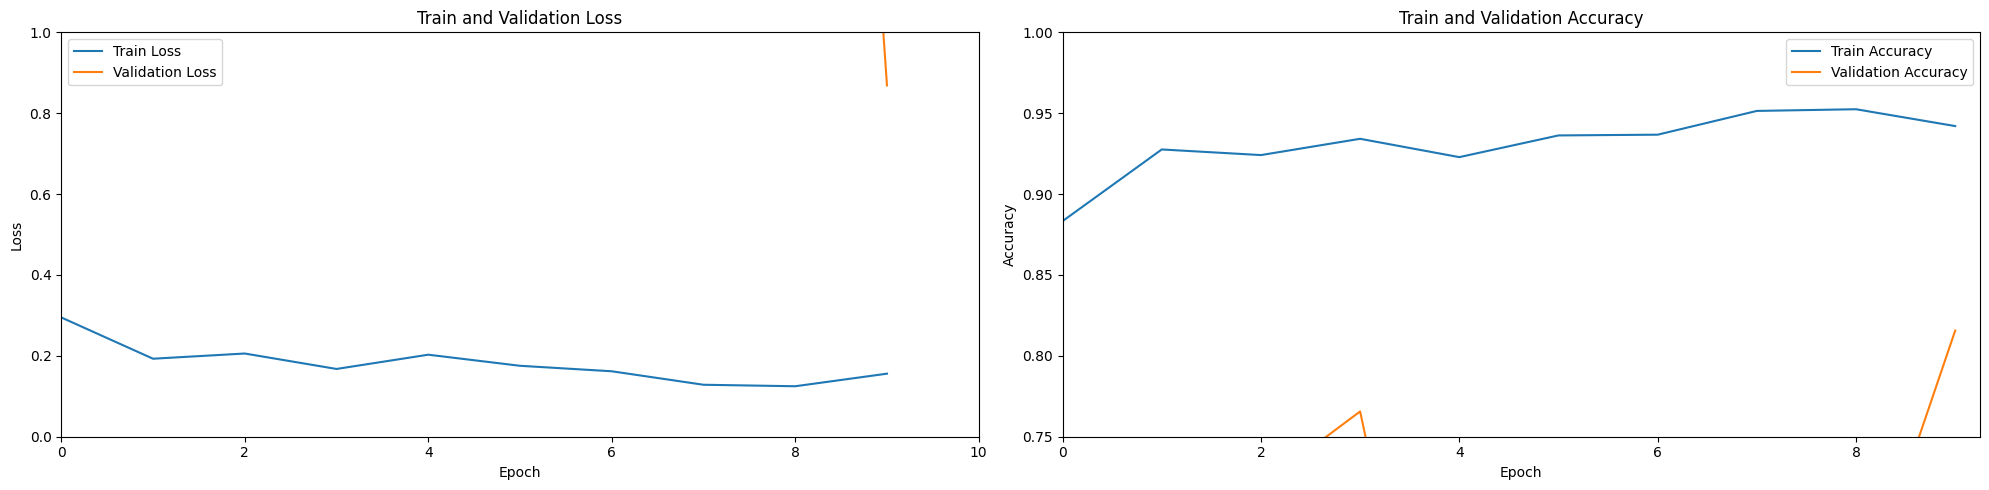

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_data.classes, y_pred))

30/30 [==============================] - 15s 469ms/step
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       500
           1       0.00      0.00      0.00       460

    accuracy                           0.52       960
   macro avg       0.26      0.50      0.34       960
weighted avg       0.27      0.52      0.36       960



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


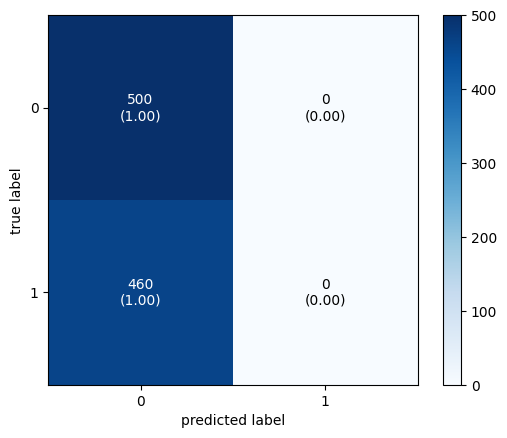

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
# calculating and plotting the confusion matrix
cm1 = confusion_matrix(test_data.classes, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
model.save('melanoma.h5')